In [190]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

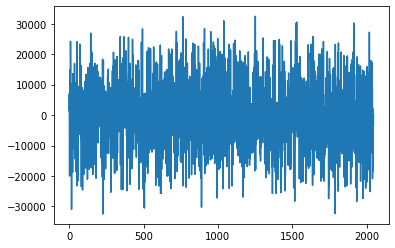

In [150]:
wave = np.fromfile('data/240611/calibrator_231001.bin' ,dtype=np.int16)
plt.plot(wave)
sampling_rate_cal=102.4e6
Ns = len(wave) # basic waveform length
Nx = 1 # number of repetitions we want to generate
Npt = Ns * Nx # total length


In [164]:
data0 = np.genfromtxt("data/240611/25mhz_240611_153549.csv", delimiter=',')[:,4]
data1 = np.genfromtxt("data/240611/25mhz_m1200ms_240611_154509.csv", delimiter=',')[:,4]
data2 = np.genfromtxt("data/240611/25mhz_m120ms_240611_154715.csv", delimiter=',')[:,4]
data3 = np.genfromtxt("data/240611/25mhz_m12ks_240611_155012.csv", delimiter=',')[:,4]
print('3')
data4 = np.genfromtxt("data/240611/25mhz_p1200ms_240611_154257.csv", delimiter=',')[:,4]
print('4')
data5 = np.genfromtxt("data/240611/25mhz_p120ms_240611_154619.csv", delimiter=',')[:,4]
print('5')
data6 = np.genfromtxt("data/240611/25mhz_p12ks_240611_154921.csv", delimiter=',')[:,4]
print('6')
sampling_rate_data = 250e6


In [167]:
wave_f = np.fft.rfft(wave)
freqs = np.fft.rfftfreq(Ns)
b_w = wave_f[181:-24:2]
f_og = freqs[181:-24:2]*sampling_rate_cal
print(f'frequency start: {f_og[0]}')
print(f'frequency end: {f_og[-1]}')
print(f'frequency steps: {(f_og[1] - f_og[0])}')

frequency start: 9050000.0
frequency end: 49950000.0
frequency steps: 100000.0


In [168]:
def get_peaks (signal, Nex=1, fbase=50e3, fstep=100e3, fmax=1e6, fdelta=30e3, sampling_rate=102.4e6):
    N = len(signal) 
    dt =  N*Nex/sampling_rate
    df = 1/dt
    window = np.hanning(N)
    signal_l = np.hstack( (signal*window, np.zeros(N*Nex-N)) )
    signal_f = np.fft.rfft(signal_l)
    freqs = []
    a_w = []
    back = []
    while fbase < fmax:
        ndx = int(fbase/df)
        delta_ndx = int(fdelta/df)
        slice = np.abs(signal_f[ndx-delta_ndx:ndx+delta_ndx])
        if len(slice) == 0: 
            break            # we reached the end            
        maxf_i = np.argmax(slice)+ndx-delta_ndx
        #print(ndx-delta_ndx,maxf_i, len(signal_f))
        back.append((maxf_i, signal_f[maxf_i]))
        freqs.append(maxf_i*df)
        a_w.append(signal_f[maxf_i])
        fbase += fstep

    signal_f *= 0
    for a,b in back:
        signal_f[a] = b
    signal_l = np.fft.irfft(signal_f)[0:N]
    return np.array(freqs), np.array(a_w), df, Nex*2*signal_l

In [160]:
def wrap_phase(x):
    return x-(np.round(x/2/np.pi))*2*np.pi

def find_dt(f_og, exp_iwt):
    dtmax = 1024/102.4e6
    print (f'dtmax: {dtmax}')
    angles = np.angle(exp_iwt)
    dts = np.linspace(-dtmax, dtmax,30000)
    def  pred(dt, ofs=0):
        return wrap_phase(ofs+f_og*dt)
    loss1 = np.array([((angles-pred(dt,0))**2).sum() for dt in dts])
    loss2 = np.array([((angles-pred(dt,np.pi))**2).sum() for dt in dts])
    loss = loss2 if loss2.min() < loss1.min() else loss1
    ofs = np.pi if loss2.min() < loss1.min() else 0
    bestdt = dts[np.argmin(loss)]

    return bestdt, pred(bestdt,ofs),ofs


In [202]:
def peaks_results(data):
    return get_peaks(data, 20, fbase=9e6+50e3, fmax=50e6, sampling_rate=sampling_rate_data)


def plots(data, title):
    print(title)
    freqs, a_w, df, sigb = peaks_results(data)
    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2)
    
    # f_og vs freqs
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(f_og, abs(freqs/f_og-1), 'ro')
    ax1.set_title('Frequency check')
    ax1.set_xlabel('freq og')
    ax1.set_ylabel('difference')
    ax1.set_ylim(0,3e-6)
    
    # get amp
    bw_conj = np.conj(b_w)
    amp_coefs = np.abs(a_w * bw_conj)
    #plot
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(f_og,amp_coefs)
    ax2.set_title('Amplitude coefs vs. frequency')
    ax2.set_xlabel('freq')
    ax2.set_ylabel('amp coefs')
        
    # phase
    exp_iwt = (a_w * bw_conj) / amp_coefs
    dtb, res,ofs = find_dt(f_og, exp_iwt)
    print(f'best dt: {dtb} \noffset: {ofs}')
    # plot
    ax3 = fig.add_subplot(gs[1, :])
#     figure(figsize=(10,5))
    ax3.plot(f_og, np.angle(exp_iwt),'bo-')
    ax3.plot(f_og, res,'r-')
    ax3.set_title('Frequency vs. phase coefs')
    ax3.set_xlabel('frequency')
    ax3.set_ylabel('phase')
    #plt.xlim(0.8e7,2e7)

    plt.tight_layout()
    plt.show()
    
    return

undrifted
1e-05
best dt: -5.1265042168072275e-06 
offset: 3.141592653589793


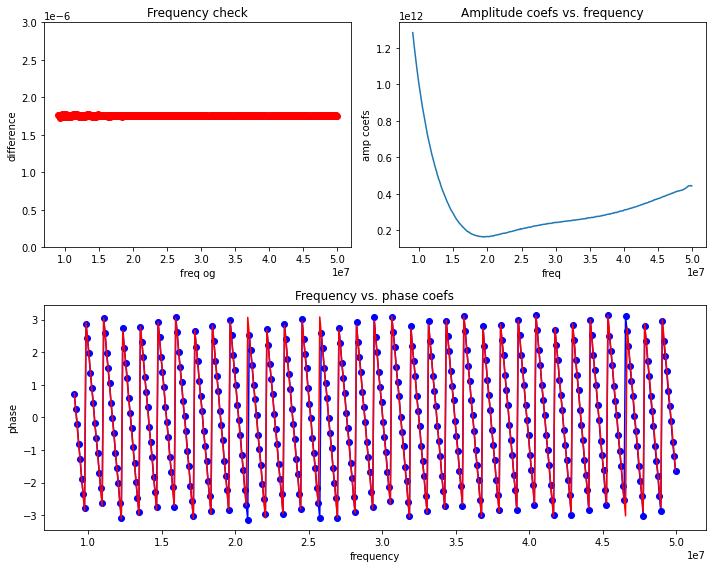

In [203]:
plots(data0, 'undrifted')

drifted: -1200m/s
1e-05
best dt: 5.027834261142039e-06 
offset: 0


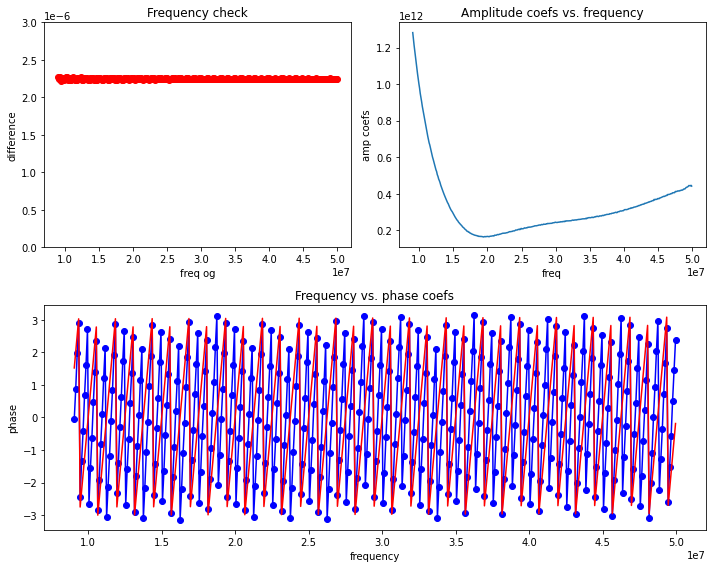

In [204]:
plots(data1, 'drifted: -1200m/s')

drifted: -120m/s
1e-05
best dt: -1.0000333344434249e-09 
offset: 0


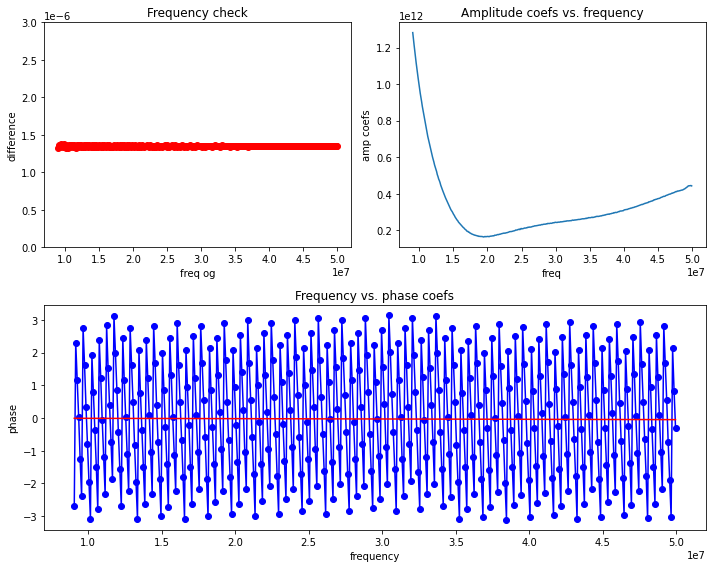

In [205]:
plots(data2, 'drifted: -120m/s')

In [207]:
plots(data3, 'drifted: -12km/s')

drifted: -12km/s


MemoryError: 

In [ ]:
plots(data4, 'drifted: +1200m/s')

In [ ]:
plots(data5, 'drifted: +120m/s')

In [ ]:
plots(data6, 'drifted: +12km/s')